In [2]:
import polars as pl
import pandas as pd

In [3]:
transactions = pl.read_parquet("data/df_transaction.pa")
train = pl.read_parquet("data/train.pa")

tran_pd = pd.read_parquet("data/df_transaction.pa")
tr_pd = pd.read_parquet("data/train.pa")


In [4]:
train_ids = set(tr_pd['client_num'].unique())
all_ids = set(tran_pd['client_num'].unique())

test_ids = all_ids - train_ids

tran_pd["is_train"] = tran_pd["client_num"].isin(train_ids)

In [5]:
tst_pd = pd.DataFrame()
tst_pd['client_num'] = list(test_ids)
tst_pd

,client_num
0,0
1,10
2,11
3,14
4,16
...,...
39138,109127
39139,109128
39140,109130
39141,109137


In [6]:
import pandas as pd
import numpy as np
import datetime

# Если нужно: преобразуем строку в datetime
# tran_pd["date_time"] = pd.to_datetime(tran_pd["date_time"])

# День недели (0=Пн, 6=Вс)
tran_pd["weekday"] = tran_pd["date_time"].dt.weekday

# Является ли выходным (Сб=5, Вс=6)
tran_pd["is_weekend"] = tran_pd["weekday"].isin([5, 6])

# Часть суток (утро/день/вечер/ночь)
def get_time_of_day(hour):
    if 5 <= hour < 12:
        return "morning"
    elif 12 <= hour < 17:
        return "day"
    elif 17 <= hour < 22:
        return "evening"
    else:
        return "night"

tran_pd["hour"] = tran_pd["date_time"].dt.hour
tran_pd["time_of_day"] = tran_pd["hour"].apply(get_time_of_day)

# День месяца и часть месяца
tran_pd["month_day"] = tran_pd["date_time"].dt.day
tran_pd["month"] = tran_pd["date_time"].dt.month
tran_pd["part_of_month"] = pd.cut(tran_pd["month_day"], bins=[0, 10, 20, 31], labels=["early", "middle", "late"])

# Флаг месяца
tran_pd["is_july"] = tran_pd["month"] == 7
tran_pd["is_august"] = tran_pd["month"] == 8
tran_pd["is_september"] = tran_pd["month"] == 9
tran_pd["is_october"] = tran_pd["month"] == 10


holidays = pd.to_datetime([
    "2024-07-01", "2024-07-02",  # выходные
    "2024-08-22",                # День флага России
    "2024-09-01",                # День знаний
    "2024-10-04"                 # День гражданской обороны
])

tran_pd["is_holiday"] = tran_pd["date_time"].dt.normalize().isin(holidays)


In [7]:
# Убедимся, что mcc_code — строка
tran_pd["mcc_code"] = tran_pd["mcc_code"].astype(str).str.zfill(4)

# Разделение на отдельные цифры
for i in range(4):
    tran_pd[f"mcc_digit_{i}"] = tran_pd["mcc_code"].str[i].astype(int)

# Скользящие пары
tran_pd["mcc_pair_01"] = tran_pd["mcc_code"].str.slice(0, 2)
tran_pd["mcc_pair_12"] = tran_pd["mcc_code"].str.slice(1, 3)
tran_pd["mcc_pair_23"] = tran_pd["mcc_code"].str.slice(2, 4)

# Скользящие тройки
tran_pd["mcc_triplet_012"] = tran_pd["mcc_code"].str.slice(0, 3)
tran_pd["mcc_triplet_123"] = tran_pd["mcc_code"].str.slice(1, 4)


# Частота использования конкретного merchant_name
merchant_freq = tran_pd["merchant_name"].value_counts()
tran_pd["merchant_freq"] = tran_pd["merchant_name"].map(merchant_freq)

# Флаг популярности
# Продавцы, у которых больше N транзакций — популярные
POPULAR_THRESHOLD = 500
tran_pd["is_popular_merchant"] = tran_pd["merchant_freq"] > POPULAR_THRESHOLD


In [8]:
# 1. Проверим наличие пропусков
tran_pd = tran_pd[tran_pd["amount"].notna()]

# 2. Вычислим границы равномерных по ширине бинов
amount_bins = np.linspace(tran_pd["amount"].min(), tran_pd["amount"].max(), 11)

# 3. Присвоим каждому amount его бин (от 0 до 9)
tran_pd["amount_bin"] = np.digitize(tran_pd["amount"], bins=amount_bins[1:-1], right=True)

# 4. One-hot encoding
amount_bin_dummies = pd.get_dummies(tran_pd["amount_bin"], prefix="amount_bin")

# 5. Добавим в датафрейм
tran_pd = pd.concat([tran_pd, amount_bin_dummies], axis=1)


In [9]:
# Сортировка
tran_pd = tran_pd.sort_values(["client_num", "date_time"])

# Скользящие метрики
tran_pd["rolling_mean_7"] = (
    tran_pd.groupby("client_num")["amount"]
    .transform(lambda x: x.rolling(window=7, min_periods=1).mean())
)

tran_pd["rolling_std_7"] = (
    tran_pd.groupby("client_num")["amount"]
    .transform(lambda x: x.rolling(window=7, min_periods=1).std().fillna(0))
)

tran_pd["rolling_mean_30"] = (
    tran_pd.groupby("client_num")["amount"]
    .transform(lambda x: x.rolling(window=30, min_periods=1).mean())
)

tran_pd["rolling_std_30"] = (
    tran_pd.groupby("client_num")["amount"]
    .transform(lambda x: x.rolling(window=30, min_periods=1).std().fillna(0))
)


In [10]:
tran_pd["week"] = tran_pd["date_time"].dt.isocalendar().week

weekly_counts = tran_pd.groupby(["client_num", "week"]).size().reset_index(name="weekly_txn_count")
weekly_stats = weekly_counts.groupby("client_num")["weekly_txn_count"].agg(
    mean_weekly_txn="mean",
    std_weekly_txn="std",
    max_weekly_txn="max"
)

max_date = tran_pd["date_time"].max()

last_activity = tran_pd.groupby("client_num")["date_time"].max().reset_index()
last_activity["days_since_last_txn"] = (max_date - last_activity["date_time"]).dt.days


In [11]:
tran_pd["year_month"] = tran_pd["date_time"].dt.to_period("M")

# Среднее по месяцам
monthly_amount = tran_pd.groupby(["client_num", "year_month"])["amount"].mean().reset_index()

# Для линейного тренда — переведем месяцы в числовую форму
monthly_amount["month_num"] = monthly_amount["year_month"].apply(lambda x: x.ordinal)

from sklearn.linear_model import LinearRegression

def compute_trend(df):
    if len(df) < 2:
        return 0
    X = df["month_num"].values.reshape(-1, 1)
    y = df["amount"].values
    model = LinearRegression()
    model.fit(X, y)
    return model.coef_[0]

trend_by_client = monthly_amount.groupby("client_num").apply(compute_trend).reset_index()
trend_by_client.columns = ["client_num", "amount_trend"]


C:\Users\Admin\AppData\Local\Temp\ipykernel_20788\3187096839.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trend_by_client = monthly_amount.groupby("client_num").apply(compute_trend).reset_index()


In [12]:
def top_n(series, n):
    vc = series.value_counts()
    top = vc.index[:n]
    return pd.Series({f"top_{i+1}": top[i] if i < len(top) else None for i in range(n)})

def extract_top_features(group):
    result = {}
    result.update(top_n(group["mcc_code"], 2).rename(lambda x: x.replace("top_", "top_mcc_")))
    result.update(top_n(group["merchant_name"], 2).rename(lambda x: x.replace("top_", "top_merchant_")))
    result.update(top_n(group["time_of_day"], 2).rename(lambda x: x.replace("top_", "top_tod_")))
    return pd.Series(result)

top_cat = tran_pd.groupby("client_num").apply(extract_top_features).reset_index()


C:\Users\Admin\AppData\Local\Temp\ipykernel_20788\583726197.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_cat = tran_pd.groupby("client_num").apply(extract_top_features).reset_index()


In [13]:
# Число уникальных торговцев
tran_pd["merchant_name"] = tran_pd["merchant_name"].astype(str)  # на всякий случай
agg_merchant = tran_pd.groupby("client_num").agg(
    unique_merchants=('merchant_name', pd.Series.nunique),
    mean_merchant_freq=('merchant_freq', 'mean'),
    max_merchant_freq=('merchant_freq', 'max'),
    popular_merchant_rate=('is_popular_merchant', 'mean')
)

# Временные признаки
agg_time = tran_pd.groupby("client_num").agg(
    weekend_rate=('is_weekend', 'mean'),
    holiday_rate=('is_holiday', 'mean')
)

# Части суток (one-hot encode и усреднение)
time_of_day_dummies = pd.get_dummies(tran_pd["time_of_day"], prefix="tod")
tran_pd = pd.concat([tran_pd, time_of_day_dummies], axis=1)

agg_tod = tran_pd.groupby("client_num")[time_of_day_dummies.columns].mean()


# Кол-во уникальных значений MCC
agg_mcc = tran_pd.groupby("client_num").agg(
    unique_mcc_pairs=('mcc_pair_01', pd.Series.nunique),
    unique_mcc_triplets=('mcc_triplet_012', pd.Series.nunique)
)

# Binned amount (one-hot), средние значения по каждому bin
amount_bin_cols = [col for col in tran_pd.columns if col.startswith("amount_bin_")]
agg_amount_bins = tran_pd.groupby("client_num")[amount_bin_cols].mean()


client_features = (
    tran_pd.groupby("client_num")
    .agg(
        count_amount=('amount', 'count'),
        avg_amount=('amount', 'mean'),
        total_amount=('amount', 'sum'),
        std_amount=('amount', 'std'),
        min_amount=('amount', 'min'),
        max_amount=('amount', 'max'),
        unique_mccs=('mcc_code', pd.Series.nunique),
        first_txn=('date_time', 'min'),
        last_txn=('date_time', 'max')
    )
    .reset_index()
)

client_features_ext = (
    client_features
    .merge(agg_merchant, on="client_num", how="left")
    .merge(agg_time, on="client_num", how="left")
    .merge(agg_tod, on="client_num", how="left")
    .merge(agg_mcc, on="client_num", how="left")
    .merge(agg_amount_bins, on="client_num", how="left")
)

tr_features = tr_pd.merge(client_features, on="client_num", how="left")
tst_features = tst_pd.merge(client_features, on="client_num", how="left")

tr_features = tr_features.sort_values("client_num").reset_index(drop=True)
tst_features = tst_features.sort_values("client_num").reset_index(drop=True)

tr_features

,client_num,target,count_amount,avg_amount,total_amount,std_amount,min_amount,max_amount,unique_mccs,first_txn,last_txn
0,1,4,240,3599.491667,863878,11704.843812,6,100000,29,2024-07-01 09:01:00,2024-09-30 17:55:00
1,2,5,300,1147.026667,344108,2629.178018,23,24496,33,2024-07-01 16:52:00,2024-09-30 19:36:00
2,3,3,147,11032.823129,1621825,86498.559476,1,1000000,21,2024-07-01 08:08:00,2024-09-30 21:56:00
3,4,5,122,1637.672131,199796,4938.356295,24,50000,9,2024-07-02 10:45:00,2024-09-30 20:34:00
4,5,2,172,391.622093,67359,1183.405909,22,10000,18,2024-07-01 02:07:00,2024-09-28 06:23:00
...,...,...,...,...,...,...,...,...,...,...,...
69995,109136,3,15,1291.800000,19377,1875.628588,55,5190,6,2024-07-04 18:10:00,2024-08-08 15:11:00
69996,109138,2,16,14767.687500,236283,20613.075561,1,59255,4,2024-08-14 10:49:00,2024-09-30 08:38:00
69997,109139,0,15,642.666667,9640,344.028169,25,1150,6,2024-07-30 14:48:00,2024-08-16 12:16:00
69998,109141,0,16,3865.187500,61843,7251.421398,170,22360,10,2024-07-08 10:23:00,2024-09-02 18:06:00


In [14]:
def add_repetition_features(df):
    df = df.copy()

    # Интервалы между транзакциями (в днях)
    df["txn_diff_days"] = (
        df.sort_values(["client_num", "date_time"])
        .groupby("client_num")["date_time"]
        .diff().dt.total_seconds().div(86400)
    )

    # Средний и STD интервал
    agg_intervals = df.groupby("client_num")["txn_diff_days"].agg(
        mean_interval_days="mean",
        std_interval_days="std"
    ).reset_index()

    return agg_intervals


In [15]:
def add_outlier_behavior(df):
    df = df.copy()

    # Отметим выбросы по amount (в пределах клиента)
    df["amount_z"] = (
        df.groupby("client_num")["amount"]
        .transform(lambda x: (x - x.mean()) / x.std(ddof=0))
    )

    df["is_amount_outlier"] = df["amount_z"].abs() > 3

    # Доля выбросов по amount
    outlier_ratio = df.groupby("client_num")["is_amount_outlier"].mean().reset_index()
    outlier_ratio.columns = ["client_num", "amount_outlier_ratio"]

    return outlier_ratio


In [16]:
def add_entropy_features(df):
    from scipy.stats import entropy
    df = df.copy()

    def calc_entropy(series):
        probs = series.value_counts(normalize=True)
        return entropy(probs)

    entropies = df.groupby("client_num").agg(
        mcc_entropy=("mcc_code", calc_entropy),
        merchant_entropy=("merchant_name", calc_entropy),
        tod_entropy=("time_of_day", calc_entropy)
    ).reset_index()

    return entropies


In [17]:
def add_recent_activity(df, days=14):
    df = df.copy()

    max_date = df["date_time"].max()
    recent_cutoff = max_date - pd.Timedelta(days=days)

    recent_df = df[df["date_time"] >= recent_cutoff]

    recent_agg = recent_df.groupby("client_num").agg(
        recent_txn_count=("amount", "count"),
        recent_amount_mean=("amount", "mean"),
        recent_amount_std=("amount", "std")
    ).reset_index()

    return recent_agg


In [18]:
def add_mcc_group_flags(df):
    df = df.copy()

    # Пример: MCC коды супермаркетов, транспорта, и т.п.
    RETAIL_MCC = {"5411", "5311", "5541"}  # grocery, department store, gas
    TRANSPORT_MCC = {"4111", "4121", "4789"}
    ECOMM_MCC = {"5964", "5815", "5816"}

    df["is_retail"] = df["mcc_code"].isin(RETAIL_MCC)
    df["is_transport"] = df["mcc_code"].isin(TRANSPORT_MCC)
    df["is_ecomm"] = df["mcc_code"].isin(ECOMM_MCC)

    mcc_flags = df.groupby("client_num").agg(
        retail_ratio=("is_retail", "mean"),
        transport_ratio=("is_transport", "mean"),
        ecomm_ratio=("is_ecomm", "mean")
    ).reset_index()

    return mcc_flags


In [19]:
repetition_features = add_repetition_features(tran_pd)
outlier_behavior = add_outlier_behavior(tran_pd)
entropy_features = add_entropy_features(tran_pd)
recent_activity = add_recent_activity(tran_pd)
mcc_group_flags = add_mcc_group_flags(tran_pd)


In [20]:
# Время между транзакциями
tran_pd = tran_pd.sort_values(["client_num", "date_time"])
tran_pd["txn_diff"] = tran_pd.groupby("client_num")["date_time"].diff().dt.total_seconds()

periodicity_stats = tran_pd.groupby("client_num")["txn_diff"].agg(
    mean_txn_diff="mean",
    std_txn_diff="std",
    min_txn_diff="min",
    max_txn_diff="max"
).reset_index()


diversity_features = tran_pd.groupby("client_num").agg(
    mcc_entropy=('mcc_code', lambda x: -np.sum((x.value_counts(normalize=True) * np.log2(x.value_counts(normalize=True) + 1e-9)))),
    merchant_entropy=('merchant_name', lambda x: -np.sum((x.value_counts(normalize=True) * np.log2(x.value_counts(normalize=True) + 1e-9))))
).reset_index()



# Часовая активность
hourly_activity = tran_pd.groupby("client_num")["hour"].agg(
    mean_hour="mean",
    std_hour="std"
).reset_index()


from scipy.stats import skew

amount_stats_extra = tran_pd.groupby("client_num")["amount"].agg(
    amount_skew="skew",
    amount_median="median",
    amount_q25=lambda x: np.percentile(x, 25),
    amount_q75=lambda x: np.percentile(x, 75),
).reset_index()


# Доля транзакций в наиболее частой категории MCC
mcc_mode = tran_pd.groupby("client_num")["mcc_code"].agg(lambda x: x.value_counts(normalize=True).iloc[0])
mcc_mode.name = "top_mcc_share"

# То же для торговцев
merchant_mode = tran_pd.groupby("client_num")["merchant_name"].agg(lambda x: x.value_counts(normalize=True).iloc[0])
merchant_mode.name = "top_merchant_share"

habit_features = pd.concat([mcc_mode, merchant_mode], axis=1).reset_index()


In [21]:
client_features_final = (
    client_features_ext
    .merge(weekly_stats, on="client_num", how="left")
    .merge(last_activity[["client_num", "days_since_last_txn"]], on="client_num", how="left")
    .merge(trend_by_client, on="client_num", how="left")
    .merge(top_cat, on="client_num", how="left")

    .merge(periodicity_stats, on="client_num", how="left")
    .merge(diversity_features, on="client_num", how="left")
    .merge(hourly_activity, on="client_num", how="left")
    .merge(amount_stats_extra, on="client_num", how="left")
    .merge(habit_features, on="client_num", how="left")

    #.merge(repetition_features, on="client_num", how="left")
    #.merge(outlier_behavior, on="client_num", how="left")
    #.merge(entropy_features, on="client_num", how="left")
    #.merge(recent_activity, on="client_num", how="left")
    #.merge(mcc_group_flags, on="client_num", how="left")
)

tr_features = tr_pd.merge(client_features_final, on="client_num", how="left")
tst_features = tst_pd.merge(client_features_final, on="client_num", how="left")

tr_features = tr_features.sort_values("client_num").reset_index(drop=True)
tst_features = tst_features.sort_values("client_num").reset_index(drop=True)


In [22]:
def preprocess_for_lgbm(df):
    df = df.copy()

    # Обработка временных колонок
    datetime_cols = df.select_dtypes(include=["datetime64"]).columns
    for col in datetime_cols:
        min_time = df[col].min()
        df[col] = (df[col] - min_time).dt.total_seconds()

    # Обработка object колонок — привести к строке (если нужно)
    object_cols = ['top_mcc_1', 'top_mcc_2', 'top_merchant_1', 'top_merchant_2', 'top_tod_1', 'top_tod_2']
    for col in object_cols:
        df[col] = df[col].astype('category')

    return df

tr_features = preprocess_for_lgbm(tr_features)
tst_features = preprocess_for_lgbm(tst_features)

In [23]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd


lgb_X = tr_features.drop(columns=["target"])
lgb_y = tr_features["target"]
lgb_X_test = tst_features

lgb_categorical_features = tr_features.select_dtypes(include=['category', 'object']).columns.tolist()

lgb_X_train, lgb_X_val, lgb_y_train, lgb_y_val = train_test_split(
    lgb_X, lgb_y, test_size=0.37, random_state=42, stratify=lgb_y
)

lgb_train_data = lgb.Dataset(lgb_X_train, label=lgb_y_train, categorical_feature=lgb_categorical_features, free_raw_data=False)
lgb_val_data = lgb.Dataset(lgb_X_val, label=lgb_y_val, categorical_feature=lgb_categorical_features, free_raw_data=False)

lgb_params = {
    "objective": "multiclass",
    "num_class": 8,
    "metric": "None",
    "learning_rate": 0.05,
    "num_leaves": 64,
    "max_depth": 7,
    "verbosity": -1,
    "seed": 42,
}

weights_by_class = {
    0: 1.00,
    1: 0.72,
    2: 0.52,
    3: 0.37,
    4: 0.27,
    5: 0.19,
    6: 0.14,
    7: 0.00,
}

def compute_wmae(y_true, y_pred):
    """WMAE без нормировки: просто среднее взвешенное абсолютное отклонение."""
    weights = np.vectorize(weights_by_class.get)(y_true)
    return np.mean(weights * np.abs(y_true - y_pred))


def feval_wmae(preds, train_data):
    """LightGBM-compatible WMAE без нормировки."""
    y_true = train_data.get_label()
    y_pred = preds.reshape(-1, 8).argmax(axis=1)
    weights = np.vectorize(weights_by_class.get)(y_true)
    error = np.mean(weights * np.abs(y_true - y_pred))
    return "wmae", error, False


model = lgb.train(
    lgb_params,
    lgb_train_data,
    valid_sets=[lgb_train_data, lgb_val_data],
    feval=feval_wmae,
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100),
    ],
)

lgb_val_preds_proba = model.predict(lgb_X_val)
lgb_val_preds_class = lgb_val_preds_proba.argmax(axis=1)
lgb_y_val_np = lgb_y_val.to_numpy()

wmae_score = compute_wmae(lgb_y_val_np, lgb_val_preds_class)
print(f"\n📊 Validation WMAE: {wmae_score:.5f}")
#0.54533

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	training's wmae: 0.519951	valid_1's wmae: 0.545328

📊 Validation WMAE: 0.54533


In [24]:
#thresholds = { 0: 0.23, 1: 0.25, 2: 0.14, 3: 0.11, 4: 0.11, 5: 0.09, 6: 0.075, 7: 0.04}
thresholds = { 
    0: 0.24, 
    1: 0.235, 
    2: 0.122, 
    3: 0.05, 
    4: 0.05, 
    5: 0.05, 
    6: 0.05, 
    7: 0.05
}



def predict_with_thresholds(probas, thresholds):
    preds = []
    for row in probas:
        above_threshold = [i for i, p in enumerate(row) if p >= thresholds[i]]
        if not above_threshold:
            preds.append(np.argmax(row))  # fallback
        else:
            # можно выбрать тот, где p * weight максимальны
            preds.append(max(above_threshold, key=lambda i: row[i] * weights_by_class[i]))
    return np.array(preds)

lgb_val_preds_custom = predict_with_thresholds(lgb_val_preds_proba, thresholds)

wmae_score = compute_wmae(lgb_y_val_np, lgb_val_preds_custom)
print(f"\n📊 Validation WMAE: {wmae_score:.5f}")
#0.52950


📊 Validation WMAE: 0.52950


In [25]:
test_preds = model.predict(lgb_X_test)
test_preds_labels = predict_with_thresholds(test_preds, thresholds)

submission = pd.DataFrame({
    "client_num": tst_features["client_num"],
    "target": test_preds_labels
})

submission.to_csv("ch_th_submission.csv", index=False)

In [30]:
test_preds
import pandas as pd

# Создаём DataFrame с вероятностями
df_proba = pd.DataFrame(
    test_preds,
    columns=[f'class_{i}' for i in range(test_preds.shape[1])]  # автоматические имена столбцов
)

# Сохраняем в CSV
df_proba.to_csv('lbg_test_preds_proba.csv', index=False)  # index=False чтобы не сохранять индексы строк

In [27]:
s

NameError: name 's' is not defined

In [ ]:
def optimize_thresholds_grid(probas, y_true, initial_thresholds, weights_by_class, compute_wmae_fn, steps=20):
    thresholds = initial_thresholds.copy()
    for class_idx in range(len(thresholds)):
        best_threshold = thresholds[class_idx]
        best_score = float('inf')
        
        # Генерируем шаги между 0 и 1
        search_space = np.linspace(0, 1, steps)
        for t in search_space:
            temp_thresholds = thresholds.copy()
            temp_thresholds[class_idx] = t
            preds = predict_with_thresholds(probas, temp_thresholds)
            score = compute_wmae_fn(y_true, preds)
            if score < best_score:
                best_score = score
                best_threshold = t
        thresholds[class_idx] = best_threshold
        print(f"✅ Optimized threshold for class {class_idx}: {best_threshold:.4f}, WMAE: {best_score:.5f}")
    return thresholds


lgb_train_preds_proba = model.predict(lgb_X)  # shape: (N, num_classes)

# 3. Подбор порогов на всём трейне
initial_thresholds = np.array([0.20, 0.25, 0.14, 0.11, 0.11, 0.09, 0.075, 0.04])

best_thresholds = optimize_thresholds_grid(
    lgb_train_preds_proba,
    lgb_y.to_numpy(),  # обязательно в numpy
    initial_thresholds,
    weights_by_class,
    compute_wmae_fn=compute_wmae,
    steps=50
)

# 4. Финальный WMAE на трейне
lgb_train_preds_custom = predict_with_thresholds(lgb_train_preds_proba, best_thresholds)
wmae_score = compute_wmae(lgb_y.to_numpy(), lgb_train_preds_custom)
print(f"\n📊 Final WMAE on full train set after threshold optimization: {wmae_score:.5f}")


✅ Optimized threshold for class 0: 0.2245, WMAE: 0.53208
✅ Optimized threshold for class 1: 0.2245, WMAE: 0.52168
✅ Optimized threshold for class 2: 0.1224, WMAE: 0.51913
✅ Optimized threshold for class 3: 0.0000, WMAE: 0.51877
✅ Optimized threshold for class 4: 0.0000, WMAE: 0.51877
✅ Optimized threshold for class 5: 0.0000, WMAE: 0.51877
✅ Optimized threshold for class 6: 0.2449, WMAE: 0.51876
✅ Optimized threshold for class 7: 0.0000, WMAE: 0.51876

📊 Final WMAE on full train set after threshold optimization: 0.51876


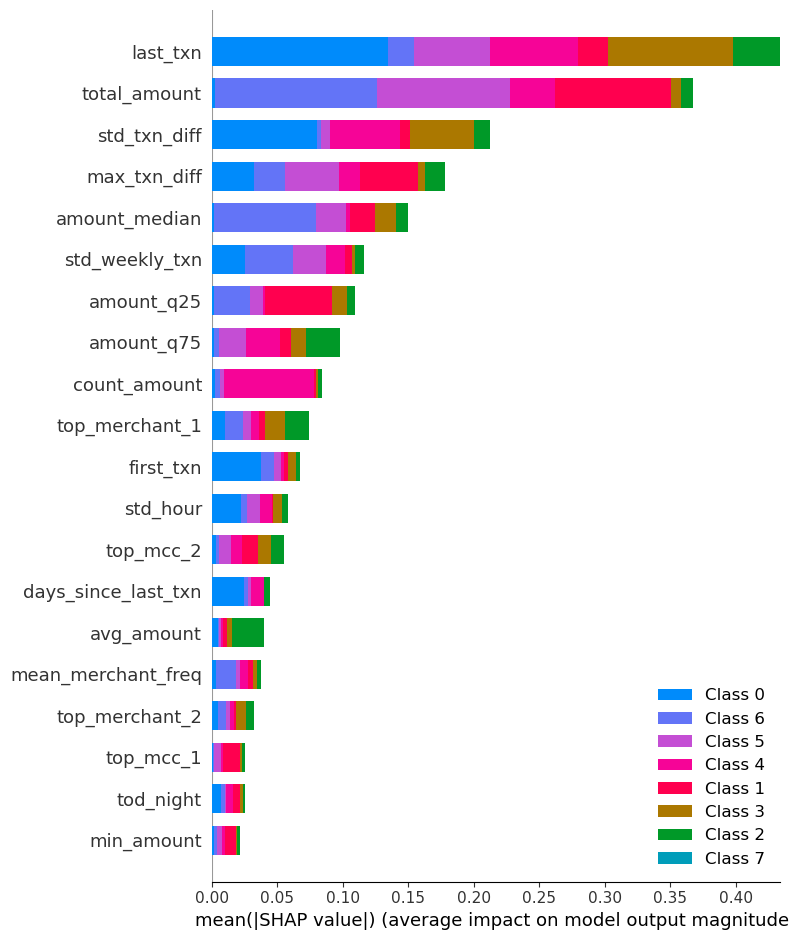

In [ ]:
import shap

# Инициализируем explainer с вашей моделью
explainer = shap.TreeExplainer(model)

# Вычисляем SHAP значения для валидационного набора (можно использовать и тренировочный)
shap_values = explainer.shap_values(lgb_X_val)

# Визуализация важности признаков (среднее абсолютное значение SHAP)
shap.summary_plot(shap_values, lgb_X_val, plot_type="bar")